# 04 - Model Architecture Exploration

This notebook compares different neural network architectures for gesture recognition.

## Architectures to Compare
1. **LSTM** - Long Short-Term Memory (original)
2. **GRU** - Gated Recurrent Unit (faster, recommended)
3. **1D-CNN** - 1D Convolutional Neural Network (fastest)
4. **Transformer** - Self-attention based (state-of-the-art)

In [2]:
# Imports
import os
import sys
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from handflow.features import FeatureEngineer
from handflow.utils import load_config
from handflow.data import load_data
from handflow.models import build_model

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Imports loaded")

/Users/huynhhuy/Documents/HandFlow/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✅ Imports loaded


In [3]:
# Configuration
config = load_config()

# Data paths
DATA_PATH = Path('../data/raw/MP_Data')
if not DATA_PATH.exists():
    DATA_PATH = Path('../ModelTraining/MP_Data')

ACTIONS = config.right_hand_gestures
SEQUENCE_LENGTH = config.model.sequence_length

print(f"📁 Data: {DATA_PATH}")
print(f"🎯 Classes: {len(ACTIONS)}")
print(f"📏 Sequence length: {SEQUENCE_LENGTH}")

📁 Data: ../data/raw/MP_Data
🎯 Classes: 8
📏 Sequence length: 16


## 1. Load and Prepare Data

In [4]:
# Load data
print("📥 Loading data...")
sequences, labels = load_data(DATA_PATH, ACTIONS, SEQUENCE_LENGTH)
print(f"   Loaded: {sequences.shape}")
print(f"   Labels: {labels.shape}")

📥 Loading data...
   Loaded: (600, 16, 84)
   Labels: (600, 8)


In [5]:
# Apply feature engineering
config.features.velocity = True
config.features.acceleration = True
config.features.finger_angles = True
config.features.hand_bbox_size = True

engineer = FeatureEngineer(config)

print("🔧 Applying feature engineering...")
X = np.array([engineer.transform(seq) for seq in sequences])
y = labels

print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Update config input dim
config.model.input_dim = X.shape[-1]
config.model.num_classes = y.shape[-1]
print(f"   Input dim: {config.model.input_dim}")
print(f"   Num classes: {config.model.num_classes}")

🔧 Applying feature engineering...
   X shape: (600, 16, 88)
   y shape: (600, 8)
   Input dim: 88
   Num classes: 8


In [6]:
# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y.argmax(axis=1))
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42, stratify=y_temp.argmax(axis=1))

print(f"📊 Data splits:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

📊 Data splits:
   Train: 418 samples
   Val:   92 samples
   Test:  90 samples


## 2. Define Training Function

In [7]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50):
    """
    Train a model and evaluate it.
    
    Returns:
        dict with metrics and training history
    """
    print(f"\n{'='*60}")
    print(f"🏗️ Training {model_name}")
    print(f"{'='*60}")
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Train
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # Measure inference time
    start_time = time.time()
    for _ in range(100):
        model.predict(X_test[:1], verbose=0)
    inference_time = (time.time() - start_time) / 100 * 1000  # ms
    
    # Predictions for confusion matrix
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)
    
    results = {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'train_time': train_time,
        'inference_time_ms': inference_time,
        'epochs_trained': len(history.history['loss']),
        'best_val_accuracy': max(history.history['val_accuracy']),
        'parameters': model.count_params(),
        'history': history.history,
        'y_pred': y_pred_classes,
        'y_true': y_true_classes
    }
    
    print(f"\n📊 Results for {model_name}:")
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   Best Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"   Parameters: {results['parameters']:,}")
    print(f"   Training Time: {train_time:.1f}s")
    print(f"   Inference Time: {inference_time:.2f}ms")
    
    return results

## 3. Train All Architectures

In [13]:
# Training settings
EPOCHS = 100  # Reduce for faster experimentation
config.training.epochs = EPOCHS

# Store results
all_results = {}

In [14]:
# 1. LSTM
config.model.architecture = 'lstm'
lstm_model = build_model(config)
all_results['LSTM'] = train_and_evaluate(
    lstm_model, 'LSTM',
    X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS
)


🏗️ Training LSTM
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3565 - loss: 1.8556 - val_accuracy: 0.5217 - val_loss: 1.4570 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4976 - loss: 1.5148 - val_accuracy: 0.5870 - val_loss: 1.2615 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5287 - loss: 1.3357 - val_accuracy: 0.5761 - val_loss: 1.1678 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5694 - loss: 1.2356 - val_accuracy: 0.5761 - val_loss: 1.1597 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6077 - loss: 1.1267 - val_accuracy: 0.6522 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6866 - loss: 0.9608 - val_accuracy: 0.7065 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6914

In [15]:
# 2. GRU
config.model.architecture = 'gru'
gru_model = build_model(config)
all_results['GRU'] = train_and_evaluate(
    gru_model, 'GRU',
    X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS
)


🏗️ Training GRU
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3469 - loss: 1.8408 - val_accuracy: 0.4783 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4354 - loss: 1.5666 - val_accuracy: 0.5435 - val_loss: 1.2762 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4785 - loss: 1.3827 - val_accuracy: 0.6413 - val_loss: 1.1357 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5981 - loss: 1.2219 - val_accuracy: 0.6848 - val_loss: 1.0068 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6435 - loss: 1.0903 - val_accuracy: 0.6739 - val_loss: 0.9737 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7081 - loss: 0.9196 - val_accuracy: 0.7391 - val_loss: 0.7233 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7584 

In [16]:
# 3. 1D-CNN
config.model.architecture = 'cnn1d'
cnn_model = build_model(config)
all_results['CNN1D'] = train_and_evaluate(
    cnn_model, 'CNN1D',
    X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS
)


🏗️ Training CNN1D
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6603 - loss: 1.0861 - val_accuracy: 0.2717 - val_loss: 1.9182 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9474 - loss: 0.3820 - val_accuracy: 0.5435 - val_loss: 1.8396 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9665 - loss: 0.2352 - val_accuracy: 0.5109 - val_loss: 1.7706 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 0.1803 - val_accuracy: 0.4891 - val_loss: 1.6434 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9593 - loss: 0.1783 - val_accuracy: 0.4565 - val_loss: 1.5542 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.1136 - val_accuracy: 0.4674 - val_loss: 1.4154 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9928 - lo

In [17]:
# 4. Transformer
config.model.architecture = 'transformer'
transformer_model = build_model(config)
all_results['Transformer'] = train_and_evaluate(
    transformer_model, 'Transformer',
    X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS
)


🏗️ Training Transformer
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3900 - loss: 1.7757 - val_accuracy: 0.5870 - val_loss: 1.2500 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5431 - loss: 1.3435 - val_accuracy: 0.6087 - val_loss: 1.0454 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5789 - loss: 1.1716 - val_accuracy: 0.6957 - val_loss: 0.9427 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5981 - loss: 1.0711 - val_accuracy: 0.7065 - val_loss: 0.8335 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6579 - loss: 0.9796 - val_accuracy: 0.6739 - val_loss: 0.8605 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6531 - loss: 0.9503 - val_accuracy: 0.8043 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.758

## 4. Compare Results

In [18]:
# Create comparison DataFrame
comparison_data = []
for name, results in all_results.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': results['test_accuracy'],
        'Best Val Accuracy': results['best_val_accuracy'],
        'Parameters': results['parameters'],
        'Train Time (s)': results['train_time'],
        'Inference (ms)': results['inference_time_ms'],
        'Epochs': results['epochs_trained']
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*80)
print("📊 MODEL COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))


📊 MODEL COMPARISON
      Model  Test Accuracy  Best Val Accuracy  Parameters  Train Time (s)  Inference (ms)  Epochs
Transformer       1.000000           1.000000       74840        9.649695       26.278720      58
        GRU       0.988889           1.000000      125640       12.613165       27.131660      48
      CNN1D       0.988889           0.989130      101000        6.665809       28.356161      66
       LSTM       0.966667           0.978261      165192       13.116488       26.743631      48


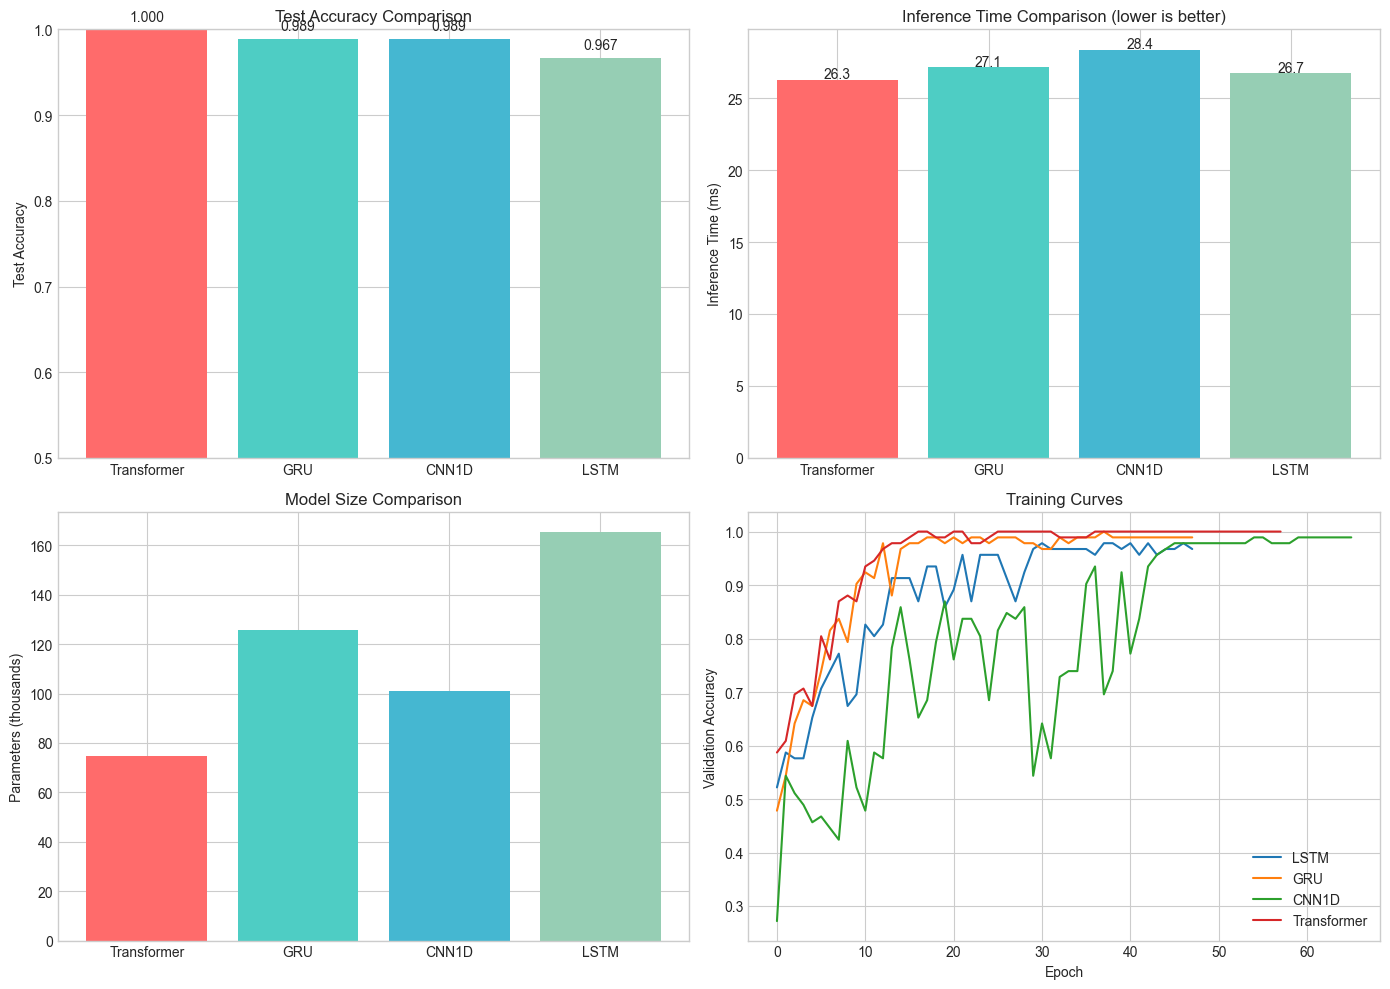

In [19]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = df_comparison['Model'].tolist()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Accuracy comparison
axes[0, 0].bar(models, df_comparison['Test Accuracy'], color=colors)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].set_ylim(0.5, 1.0)
for i, v in enumerate(df_comparison['Test Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Inference time
axes[0, 1].bar(models, df_comparison['Inference (ms)'], color=colors)
axes[0, 1].set_ylabel('Inference Time (ms)')
axes[0, 1].set_title('Inference Time Comparison (lower is better)')
for i, v in enumerate(df_comparison['Inference (ms)']):
    axes[0, 1].text(i, v + 0.1, f'{v:.1f}', ha='center')

# Parameters
axes[1, 0].bar(models, df_comparison['Parameters'] / 1000, color=colors)
axes[1, 0].set_ylabel('Parameters (thousands)')
axes[1, 0].set_title('Model Size Comparison')

# Training curves
for name, results in all_results.items():
    history = results['history']
    axes[1, 1].plot(history['val_accuracy'], label=name)

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Training Curves')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../docs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Confusion Matrices

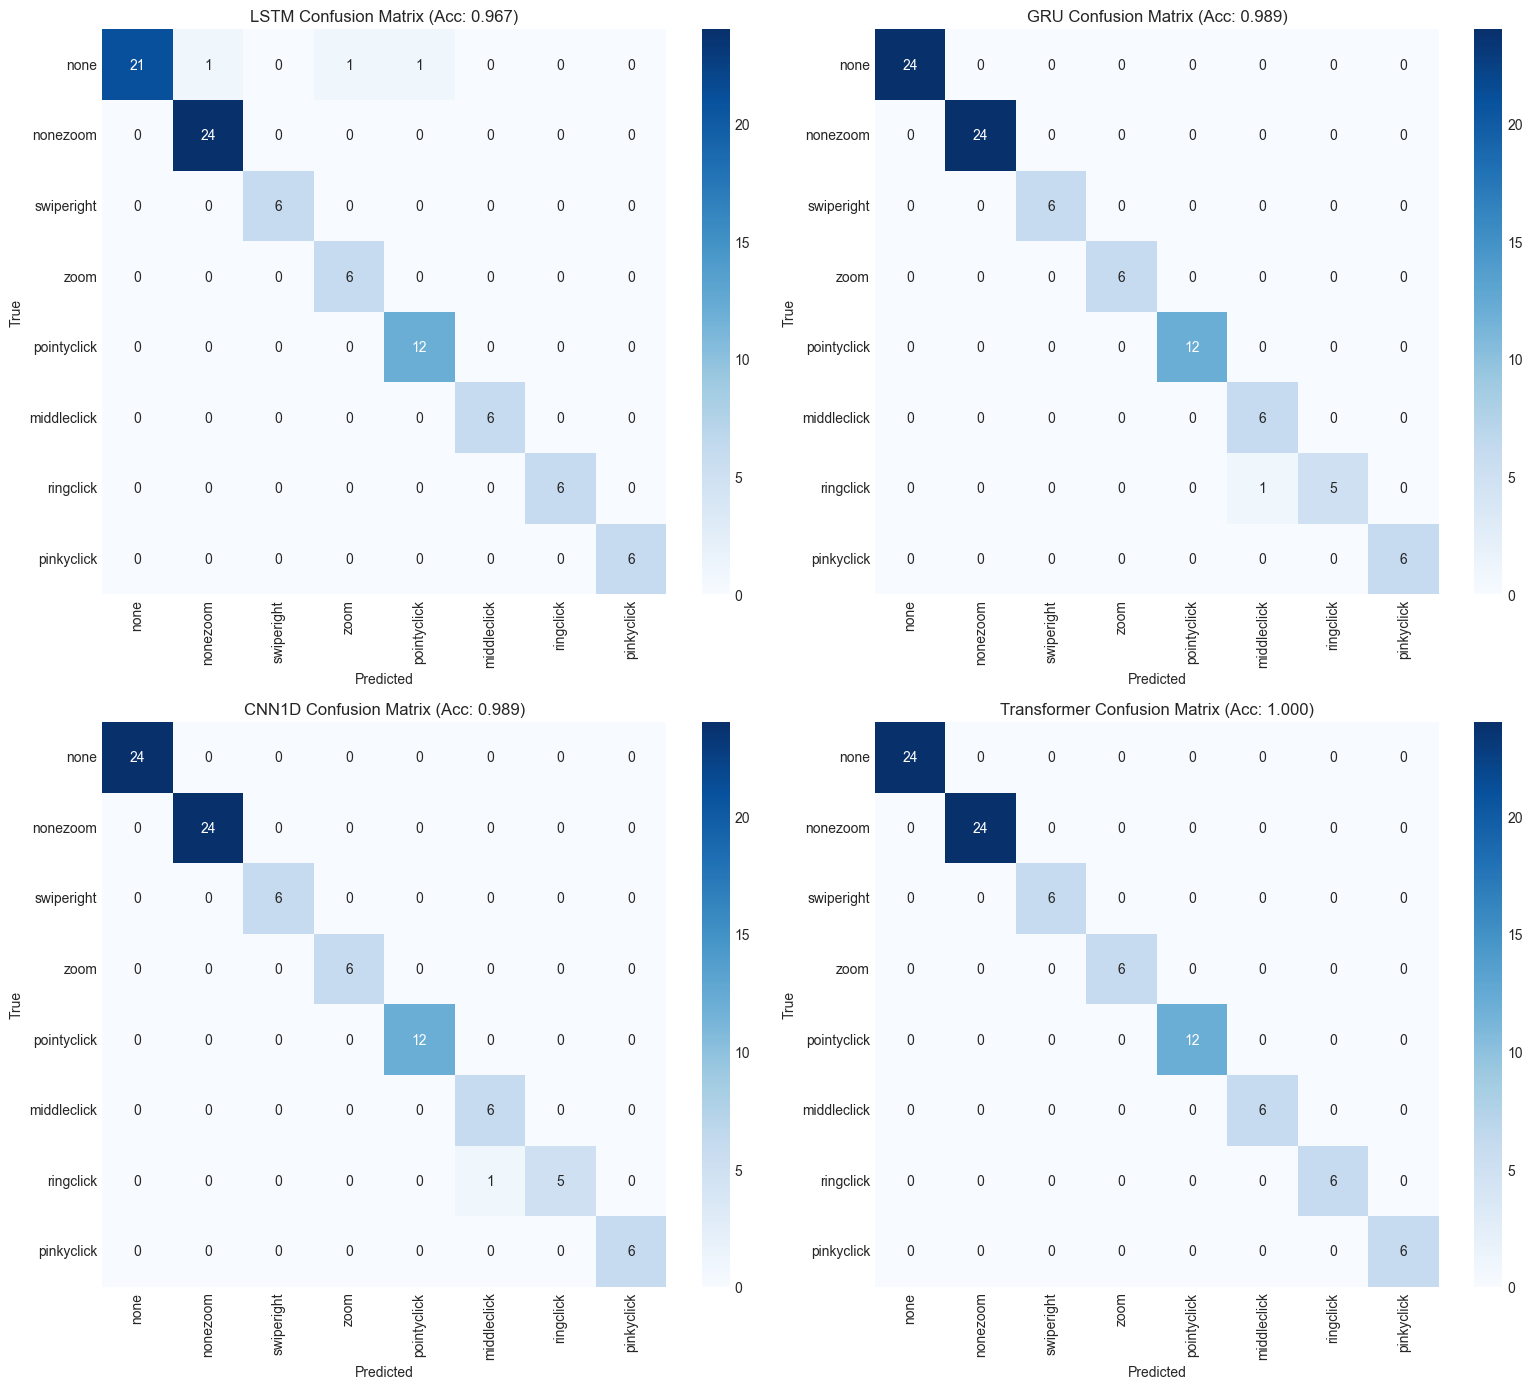

In [20]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (name, results) in enumerate(all_results.items()):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=ACTIONS, yticklabels=ACTIONS,
        ax=axes[idx]
    )
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    axes[idx].set_title(f'{name} Confusion Matrix (Acc: {results["test_accuracy"]:.3f})')

plt.tight_layout()
plt.savefig('../docs/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Best Model Analysis

In [21]:
# Find best model
best_model_name = df_comparison.iloc[0]['Model']
best_results = all_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print()
print(classification_report(
    best_results['y_true'],
    best_results['y_pred'],
    target_names=ACTIONS
))


🏆 Best Model: Transformer

              precision    recall  f1-score   support

        none       1.00      1.00      1.00        24
    nonezoom       1.00      1.00      1.00        24
  swiperight       1.00      1.00      1.00         6
        zoom       1.00      1.00      1.00         6
 pointyclick       1.00      1.00      1.00        12
 middleclick       1.00      1.00      1.00         6
   ringclick       1.00      1.00      1.00         6
  pinkyclick       1.00      1.00      1.00         6

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



## 7. Summary & Recommendations

In [22]:
print("="*60)
print("📋 MODEL EXPLORATION SUMMARY")
print("="*60)
print()
print("📊 COMPARISON RESULTS:")
print(df_comparison[['Model', 'Test Accuracy', 'Inference (ms)']].to_string(index=False))
print()
print("🏆 RECOMMENDATIONS:")
print()
print(f"   BEST ACCURACY: {df_comparison.iloc[0]['Model']}")
print(f"   → Use for maximum accuracy")
print()

fastest = df_comparison.loc[df_comparison['Inference (ms)'].idxmin()]
print(f"   FASTEST: {fastest['Model']} ({fastest['Inference (ms)']:.1f}ms)")
print(f"   → Use for real-time with limited CPU")
print()

# Find best balance (accuracy/speed ratio)
df_comparison['Score'] = df_comparison['Test Accuracy'] / (df_comparison['Inference (ms)'] + 1)
balanced = df_comparison.loc[df_comparison['Score'].idxmax()]
print(f"   BALANCED (Acc/Speed): {balanced['Model']}")
print(f"   → Best for production use")
print()
print("💡 GENERAL GUIDANCE:")
print("   • GRU: Good default choice (fast + accurate)")
print("   • CNN1D: Use if CPU is limited")
print("   • LSTM: Slightly more accurate, slower")
print("   • Transformer: Best with lots of data")
print("="*60)

📋 MODEL EXPLORATION SUMMARY

📊 COMPARISON RESULTS:
      Model  Test Accuracy  Inference (ms)
Transformer       1.000000       26.278720
        GRU       0.988889       27.131660
      CNN1D       0.988889       28.356161
       LSTM       0.966667       26.743631

🏆 RECOMMENDATIONS:

   BEST ACCURACY: Transformer
   → Use for maximum accuracy

   FASTEST: Transformer (26.3ms)
   → Use for real-time with limited CPU

   BALANCED (Acc/Speed): Transformer
   → Best for production use

💡 GENERAL GUIDANCE:
   • GRU: Good default choice (fast + accurate)
   • CNN1D: Use if CPU is limited
   • LSTM: Slightly more accurate, slower
   • Transformer: Best with lots of data


## 8. Save Best Model

In [28]:
# Save the best model for production
SAVE_MODEL = True  # Set to True to save

if SAVE_MODEL:
    # Get the actual model object
    if best_model_name == 'LSTM':
        best_model = lstm_model
    elif best_model_name == 'GRU':
        best_model = gru_model
    elif best_model_name == 'CNN1D':
        best_model = cnn_model
    else:
        best_model = transformer_model
    
    save_path = Path('../models/experiment_best.keras')
    best_model.save(save_path)
    print(f"✅ Saved best model ({best_model_name}) to {save_path}")
else:
    print("⏭️ Model saving skipped. Set SAVE_MODEL=True to save.")

✅ Saved best model (Transformer) to ../models/experiment_best.keras


## Next Steps

1. **Choose your architecture** based on results above
2. **Train full model** using `python scripts/train.py --hand right --architecture <choice>`
3. **Quantize for production** using `python scripts/quantize_model.py`
4. **Test real-time** using `handflow run`